<a href="https://colab.research.google.com/github/Dileep759/ProjectsFlipRobo/blob/main/Malignant_Comments_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
import re

In [1]:
from google.colab import files
  
  
uploaded = files.upload()

Saving train1.csv to train1.csv


In [2]:
df=pd.read_csv("train1.csv")
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [36]:
print(df.shape)

(159571, 8)


In [4]:
print(df.dtypes)

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object


Hence we have a sufficiently large dataset consistly of 159571 samples. Each sample contains 8 fields.
It was observed that running train_test_split on the heavy preprocessed dataframe sometimes resulted in system going out of memory. Hence to avoid such cases, one extra line of code was added. The df.reindex code will shuffle the indices initially, so that later splitting dataset into training and testing will give fairer results.

In [5]:
df = df.reindex(np.random.permutation(df.index))

# Separate the comment field data and outcome labels

In [6]:
import warnings
warnings.filterwarnings('ignore')
comment = df['comment_text']
print(comment.head())
comment = comment.to_numpy()

151155    "This entire article, apart from being a mess,...
8335      If you wish to quote higher figure, contact ei...
98385     Myth? \n\nThis sounds exactly like the myth of...
46424     I think most (if not all) of the other UK Sing...
82378     Erachima, there is no dramatic conflict going ...
Name: comment_text, dtype: object


In [7]:
label = df[['malignant', 'highly_malignant' , 'rude' , 'threat' , 'abuse' , 'loathe']]
print(label.head())
label = label.to_numpy()

        malignant  highly_malignant  rude  threat  abuse  loathe
151155          0                 0     0       0      0       0
8335            0                 0     0       0      0       0
98385           0                 0     0       0      0       0
46424           0                 0     0       0      0       0
82378           0                 0     0       0      0       0


In [8]:
df['malignant'].value_counts()

0    144277
1     15294
Name: malignant, dtype: int64

In [9]:
df['highly_malignant'].value_counts()

0    157976
1      1595
Name: highly_malignant, dtype: int64

In [10]:
df['rude'].value_counts()

0    151122
1      8449
Name: rude, dtype: int64

In [11]:
df['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [12]:
df['abuse'].value_counts()

0    151694
1      7877
Name: abuse, dtype: int64

In [13]:
df['loathe'].value_counts()

0    158166
1      1405
Name: loathe, dtype: int64

I had a dataset of 159571 samples of comments along with their labels. I observed that every 1 in 10 samples was malignant, every 1 in 17 and 19 samples were rude and abuse respectively, but the occurrences of sample being highly_malignant(1 in 100), threat(1 in 332) and loathe(1 in 112) was extremely rare.

In [14]:
df.isnull().values.any()

False

In [15]:
df.drop_duplicates(inplace = True)

In [16]:
df.shape

(159571, 8)

In [17]:
ct1,ct2 = 0,0
for i in range(label.shape[0]):
    ct = np.count_nonzero(label[i])
    if ct :
        ct1 = ct1+1
    if ct>1 :
        ct2 = ct2+1
print(ct1)
print(ct2)

16225
9865


I had a dataset of 159571 samples of comments along with their labels, but I observed that among all these samples of comments there were only 26090 comments with atleast one label non-zero.

i.e - out of six samples of comments 1 sample has atleast 1 label, which is non-zero

# Data Visualisations
Let us analyse the no. of comments having lengths varying from 0 to 1200

average length of comment: 394.139


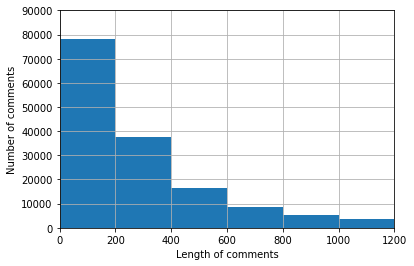

In [20]:
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

From the first visualisation we can observe that comments were of varying lengths from less than 200 characters to 1200 characters. The majority of comments had length up to 200.

For the next visualisation, I had length of comments on the independent axis again similar to the previous plot. But instead of counting number of comments, I counted comments belonging to each of the different categories.

Number of comments classified as Malignant, Highly_malignant ,....etc depending on their lengths

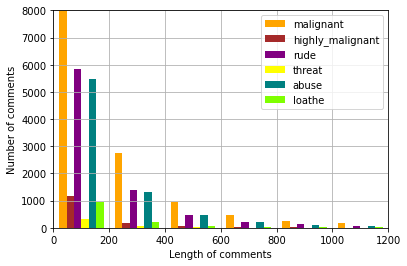

In [21]:
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['malignant','highly_malignant','rude','threat','abuse','loathe']
color = ['orange','brown','purple','yellow','teal','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 8000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

From above plot we observe that for all the length of comments Malignant label has highest count followed by rude 

Since including very long length comments for training increased the number of words manifold, the kernel was unable to handle the required memory. It was required to trim the data effectively, so as to not miss essential features and loose accuracy. Setting 400 characters as the threshold included up to 80% of the data and hence appeared to be a good choice. (We had less words in total, but the percentage of toxic words captured were more).

In [18]:
comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [19]:
labels = np.asarray(labels)

In [20]:
print(len(comments))

115893


Hence, after removing comments longer than 400 characters, we are still left with more than 115893 comments, which seems enough for training purposes.

# Preprocessing

# Preparing a string containing all punctuations to be removed
The string library contains punctuation characters. This is imported and all numbers are appended to this string. Also, we can notice that our comment_text field contains strings such as won't, didn't, etc which contain apostrophe character('). To prevent these words from being converted to wont/didnt, the character ' represented as \' in escape sequence notation is replaced by empty character in the punctuation string.

maketrans() returns a translation table that maps each character in the punctuation_edit into the character at the same position in the outtab string i.e. it replaces every character in the removal list with a space, since outtab contains a string with spaces.

In [21]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


In [23]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32913 sha256=7ccdcaceeb24b4dee38dd7852c0067d4e112e807e5719254dc883098955b8b78
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


# Updating the list of stop words
Stop words are those words that are frequently used in both written and verbal communication and thereby do not have either a positive/negative impact on our statement.E.g. is, this, us,etc.

Single letter words if existing or created due to any preprocessing step do not convey any useful meaning and hence can be directly removed. Hence letters from b to z, will be added to the list of stop words imported directly.

In [22]:
from stop_words import get_stop_words
stop_words = get_stop_words('english')
stop_words.append('')

for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))

In [23]:
print (stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

# Stemming and Lemmatizing

Stemming is the process of converting inflected/derived words to their word stem or the root form. Basically, a large number of similar origin words are converted to the same word.E.g. words like "stems", "stemmer", "stemming", "stemmed" as based on "stem". This helps in achieving the training process with a better accuracy.

Lemmatizing is the process of grouping together the inflected forms of a word so they can be analysed as a single item. This is quite similar to stemming in its working but differs since it depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.

The wordnet library in nltk will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.

In [24]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [25]:
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()

# We can now, loop once through all the comments applying :

In [28]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [26]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

In [30]:
!pip install scikit-learn

# Applying Count Vectorizer

Here we can finally convert our comments into a matrix of token counts, which signifies the number of times it occurs.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

#create object supplying our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#fitting it to converts comments into bag of words format
tf = count_vector.fit_transform(comments).astype(np.uint8)

In [ ]:
tf=tf.toarray()

In [26]:
print(tf.shape)

(115893, 72292)


Hence from its shape we can imply that after all preprocessing we have a list of 72292 words in total.

# Splitting dataset into training and testing

Since the system was going out of memory using train_test_split, I had jumbled all the indexes in the beginning itself.

The shuffle function defined here performs the task of assigning first 2/3rd values to train and remaining 1/3rd values to the test set.

In [69]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)

(38631, 72292)
(77262, 72292)


# Implementation :
    
Let us define all the evaluation metrics

In [29]:
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

In [30]:
def evaluate_score(Y_test,predict):
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))
    
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    
    precision = precision_score(Y_test, predict, average='weighted')
    print('Precision: {}'.format(precision*100))
    
    recall = recall_score(Y_test, predict, average='weighted')
    print('Recall: {}'.format(recall*100))

# Starting with the First Model -

Problem Transformation Methods :

These include the Binary Relevance, Label Powerset and Classifier Chain methods. Implementations of these methods is available in the scikit-multilearn library.

I will be implementing the most basic method,which is the Binary Relevance method from scratch. It does not take into account the interdependence of labels and basically creates a separate classifier for each of the labels.

In [36]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.9MB/s 


## 1. Binary Relevance (BR) Method with MultinomialNB classifiers (from scratch)

In [32]:
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance

In [42]:
classifier=BinaryRelevance(classifier=MultinomialNB(),require_dense=[False,True])
classifier.fit(X_train,Y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[False, True])

In [43]:
predictions=classifier.predict(X_test)

In [44]:
evaluate_score(Y_test,predictions)

Accuracy : 88.28143201056147
Log_loss : 1.8300274053463077
Hamming_loss : 3.212877395528634
Precision: 62.0566719116894
Recall: 59.23774584734536


## 2. BR Method with SVM classifier (from scikit-multilearn)

In [33]:
from sklearn.svm import SVC
classifier2 = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier2.fit(X_train, Y_train)

BinaryRelevance(classifier=SVC(C=1.0, break_ties=False, cache_size=200,
                               class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3,
                               gamma='scale', kernel='rbf', max_iter=-1,
                               probability=False, random_state=None,
                               shrinking=True, tol=0.001, verbose=False),
                require_dense=[False, True])

In [34]:
#predictions
predictions = classifier2.predict(X_test)

In [35]:
evaluate_score(Y_test,predictions)

Accuracy : 90.59045844011287
Log_loss : 1.777756978514857
Hamming_loss : 2.2840033479157498
Precision: 86.27197593852149
Recall: 54.87901626338755


## Adaptation Algorithms

## 3. MLkNN with k=2 (from scikit-multilearn)
This is the adapted multi-label version of K Nearest Neighbours. Its implementation is available in the multilearn library.

In [ ]:
#create and fit classifier
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=2)
classifier.fit(X_train, Y_train)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
evaluate_score(Y_test,predictions)

Accuracy : 84.58750744220961
Log_loss : 1.2611861880143975
Hamming_loss : 4.384216475542095
Precision: 50.49687329640824
Recall: 46.841430964817185


## 4. BP-MLL Neural Networks (from scratch)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [ ]:
model = Sequential()
model.add(Dense(4, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 289172    
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30        
Total params: 289,202
Trainable params: 289,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.myneural.h5py', 
                               verbose=1, save_best_only=True)
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
2415/2415 [==============================] - 18s 7ms/step - loss: 0.5555 - accuracy: 0.4830
Epoch 2/10
2415/2415 [==============================] - 18s 7ms/step - loss: 1.0130 - accuracy: 0.2859
Epoch 3/10
2415/2415 [==============================] - 17s 7ms/step - loss: 1.3920 - accuracy: 0.0972
Epoch 4/10
2415/2415 [==============================] - 16s 7ms/step - loss: 1.6073 - accuracy: 0.1244
Epoch 5/10
2415/2415 [==============================] - 16s 7ms/step - loss: 1.7638 - accuracy: 0.1735
Epoch 6/10
2415/2415 [==============================] - 18s 7ms/step - loss: 2.0838 - accuracy: 0.4493
Epoch 7/10
2415/2415 [==============================] - 17s 7ms/step - loss: 2.4751 - accuracy: 0.4448
Epoch 8/10
2415/2415 [==============================] - 18s 7ms/step - loss: 2.9604 - accuracy: 0.4491
Epoch 9/10
2415/2415 [==============================] - 20s 8ms/step - loss: 3.4167 - accuracy: 0.4433
Epoch 10/10
2415/2415 [==============================] - 18s 7ms/step - l

In [ ]:
predict = model.predict(X_test)

In [ ]:
print(predict[0])

[9.6000606e-01 0.0000000e+00 3.9993498e-02 0.0000000e+00 4.0257436e-07
 0.0000000e+00]


Since the results returned by the model are in the form of probabilities, they have to be explicitly converted to either 0/1 using the round function. This is because the hamming_loss and accuracy_score cannot work on these values directly. However, log loss can compute loss directly without modifying the values.

In [ ]:
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))
precision = precision_score(Y_test, predict, average='weighted')
print('Precision: {}'.format(precision*100))
recall = recall_score(Y_test, predict, average='weighted')
print('Recall: {}'.format(recall*100))

Log_loss : 4.135400330646042
Hamming_loss : 3.345327155220764
Accuracy : 88.78361937304237
Precision: 38.562623258488706
Recall: 25.11786538268633


## Let us try improving the BP-MLL model (Refining)

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers

#define parameters for using in param grid
nodes = [16, 32] # number of nodes in the hidden layer
lrs = [0.001, 0.002] # learning rate, default = 0.001
epochs = [10,20]
batch_size = 64

In [ ]:
def create_model(nodes=10,lr=0.001):
    model = Sequential()
    model.add(Dense(nodes, activation='relu', input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))
    opt = optimizers.RMSprop(lr=lr)
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

In [ ]:
#start fitting process
param_grid = dict(epochs=epochs,nodes=nodes, lr=lrs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,refit=True,verbose=2)
grid_result = grid.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Epoch 1/10
1932/1932 [==============================] - 46s 24ms/step - loss: 0.6353 - accuracy: 0.2676
Epoch 2/10
1932/1932 [==============================] - 46s 24ms/step - loss: 1.2377 - accuracy: 0.2767
Epoch 3/10
1932/1932 [==============================] - 46s 24ms/step - loss: 1.7022 - accuracy: 0.2772
Epoch 4/10
1932/1932 [==============================] - 46s 24ms/step - loss: 2.2915 - accuracy: 0.2778
Epoch 5/10
1932/1932 [==============================] - 48s 25ms/step - loss: 3.1121 - accuracy: 0.3373
Epoch 6/10
1932/1932 [==============================] - 51s 26ms/step - loss: 4.1894 - accuracy: 0.3502
Epoch 7/10
1932/1932 [==============================] - 56s 29ms/step - loss: 5.4490 - accuracy: 0.3595
Epoch 8/10
1932/1932 [==============================] - 53s 28ms/step - loss: 6.7750 - accuracy: 0.3109
Epoch 9/10
1932/1932 [==============================] - 46s 24ms/step - loss: 8.4653 - accuracy: 0.3806
Epoc

In [ ]:
print(grid_result)

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001FDA255AAF0>,
             n_jobs=1,
             param_grid={'epochs': [10, 20], 'lr': [0.001, 0.002],
                         'nodes': [16, 32]},
             verbose=2)


In [ ]:
print('Best estimator : {}'.format(grid.best_estimator_))
print('Best score : {}'.format(grid.best_score_))
print('Best params : {}'.format(grid.best_params_))

Best estimator : <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001FDAA8A9220>
Best score : 0.5097691133618355
Best params : {'epochs': 20, 'lr': 0.002, 'nodes': 32}


In [ ]:
print(grid.cv_results_)

{'mean_fit_time': array([ 494.86758976,  882.14677353,  477.9971127 ,  916.88046474,
        946.94261413, 1797.00441146,  962.86820879, 1724.06636071]), 'std_fit_time': array([ 6.54266998,  9.04356508,  8.03429174, 20.39105651,  7.34210253,
       31.10282033, 82.19042564, 37.26262965]), 'mean_score_time': array([1.09999709, 1.88745875, 1.04539094, 1.80274229, 2.68720894,
       1.0985589 , 6.74938922, 8.33918695]), 'std_score_time': array([ 0.11875915,  1.84593402,  0.12939676,  0.52630865,  3.41144698,
        0.12642677, 11.21542666, 13.54751822]), 'param_epochs': masked_array(data=[10, 10, 10, 10, 20, 20, 20, 20],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_lr': masked_array(data=[0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_nodes': masked_array(data=

In [ ]:
predictions = grid.predict(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings
predict = grid.predict_proba(X_test)
print(predict.shape)

(38631, 6)


In [ ]:
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))

Log_loss : 2.4157717080569445
Hamming_loss : 19.0438594220531
Accuracy : 0.12942973259817245


In [ ]:
import matplotlib.cm as cm
import itertools

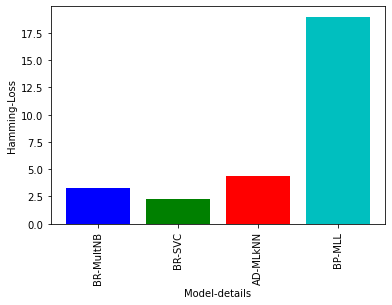

In [ ]:
x = ['BR-MultNB','BR-SVC','AD-MLkNN','BP-MLL']
y = [3.26,2.25,4.38,19.0]
colors = itertools.cycle(['b', 'g', 'r', 'c'])
plt.ylabel('Hamming-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

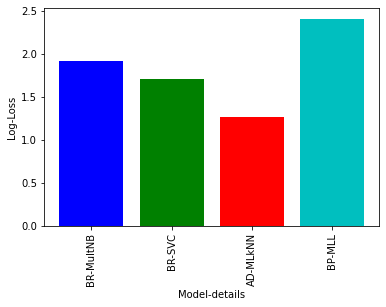

In [ ]:
x = ['BR-MultNB','BR-SVC','AD-MLkNN','BP-MLL']
y = [1.92,1.71,1.26,2.41]
colors = itertools.cycle(['b', 'g', 'r', 'c'])
plt.ylabel('Log-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

It was a key point to note that almost all models generated by problem transformation methods had low values of hamming losses, whereas models generated by the adaptive algorithm approach had low values of log-losses.

In [37]:
import joblib
file='SVC-BR.pkl'
joblib.dump(classifier2,file)

['SVC-BR.pkl']

## predict the output for test data through the best model

In [42]:
from google.colab import files
  
  
uploaded = files.upload()

Saving test1.csv to test1 (2).csv


In [46]:
df2=pd.read_csv("test1 (2).csv")
df2.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [47]:
df2.isnull().values.any()

False

In [48]:
df2.drop_duplicates(inplace = True)

In [49]:
print(df2.shape)

(153164, 2)


In [50]:
df2 = df2.reindex(np.random.permutation(df2.index))

In [51]:
comment2 = df2['comment_text']
print(comment2.head())
comment2 = comment2.to_numpy()

87669    == My promotion to admin == \n I was expecting...
19854    == Jews? == \n\n Hello, \n\n Where you wrote t...
2608     " \n\n :No. Applications frequently assume tha...
49017    I have a suggestion to alleviate this nonsense...
48477    == Image == \n\n I removed the current image. ...
Name: comment_text, dtype: object


average length of comment: 364.875


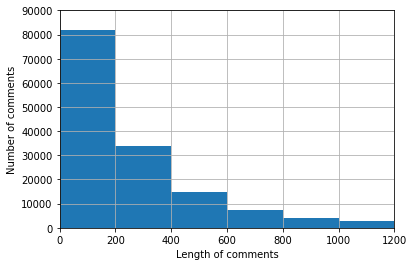

In [52]:
x2 = [len(comment2[i]) for i in range(comment2.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x2)/len(x2)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x2, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

In [53]:
comments2 = []

for ix in range(comment2.shape[0]):
    if len(comment2[ix])<=400:
        comments2.append(comment2[ix])

In [54]:
print(len(comments2))

115769


In [55]:
for i in range(len(comments2)):
    comments2[i] = comments2[i].lower().translate(trantab)
    l2 = []
    for word in comments2[i].split():
        l2.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments2[i] = " ".join(l2)

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

#create object supplying our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#fitting it to converts comments into bag of words format
tf2 = count_vector.fit_transform(comments2).astype(np.uint8)

In [ ]:
tf2=tf2.toarray()

In [57]:
print(tf2.shape)

(115769, 95799)


In [58]:
import joblib
loadm=joblib.load('SVC-BR.pkl')

In [68]:
pred=loadm.predict(tf2[:,0:72292])

In [73]:
pred.shape

(115769, 6)

In [70]:
evaluate_score(Y_test,pred[0:38631,:])

Accuracy : 88.24260309078201
Log_loss : 0.4684932980759391
Hamming_loss : 4.361781988558412
Precision: 5.027183423944746
Recall: 0.019833399444664817


In [76]:
pred=pd.DataFrame(pred)

In [77]:
pred.to_csv("predmcc.csv")